In [1]:
import sys

sys.path.append("..")

### Test

In [2]:
import os
from typing import List, Dict
from pathlib import Path
from PIL import Image
from segment.utils import resize_image_pil
from segment.dino_script import get_dino_results
from segment.sam_script import get_sam_results
from segment.utils import get_device
from segment.sam_results import SAMResults
from diffusers.utils import load_image
from segment.sam_script import get_sam_results
from segment.utils import get_coco_style_polygons
import yaml
from datasets import load_dataset, Dataset
from typing import List, Dict 
from datasets import Dataset, concatenate_datasets
from typing import List, Dict
from PIL import Image
import math
from tqdm.auto import tqdm 
from segment.utils import *

# disable datasets.map progress bar
from datasets.utils.logging import disable_progress_bar
disable_progress_bar()

os.environ["TOKENIZERS_PARALLELISM"] = "false"


# Function for resizing an image to a specific size without changing the aspect ratio
def load_resize_image(image_path: str | Image.Image, size: int) -> Image.Image:
    if isinstance(image_path, str):
        image_pil = load_image(image_path).convert("RGB")
    else:
        image_pil = image_path.convert("RGB")

    image_pil = resize_image_pil(image_pil, size)
    return image_pil


# Simple function for getting the masks based on a prompt
def load_all_in_sam(images, unformatted_results, labels_dict):
    results = []
    for image, uf in zip(images, unformatted_results):
        try:
            result = SAMResults(image, labels_dict, **uf, person_masks_only=False).formatted_results
        except Exception as e:
            print(f"One Image had an error: {e}")
            result = [{}]
            
        results.append(result)
    return results


def get_metadata(
    text_prompt,
    image_paths: List[str | Image.Image],
    labels_dict: Dict[str, int],
    size: int = 1024,
    **kwargs,
) -> List[Dict]:
    device = get_device()

    assert bool(image_paths), "No images provided"

    # Load and resize the images
    images = [load_resize_image(im, size) for im in image_paths]

    # Get the boxes from the prompts using DINO
    dino_results = get_dino_results(images, text_prompt, device, **kwargs)
    
     # Get the masks from the images and boxes using SAM
    unformatted_results = get_sam_results(images, dino_results, text_prompt, device)

    return load_all_in_sam(images, unformatted_results, labels_dict)

# loading yaml config file
def load_yaml(path):
    with open(path, "r") as file:
        data = yaml.load(file, Loader=yaml.FullLoader)
    return data


# Get the labels dictionary from the config file
def get_labels_dict(config_path):
    data = load_yaml(config_path)
    labels_dict = data.get("names")
    labels_dict = {v: k for k, v in labels_dict.items()}
    return labels_dict

def filter_list_in_column(dataset: Dataset, column_name: str, filter_function):
    """
    Apply a filter function to a column containing lists of dictionaries.
    
    :param dataset: The input dataset
    :param column_name: The name of the column containing lists to filter
    :param filter_function: A function that takes a dictionary and returns True to keep it, False to filter it out
    :return: A new dataset with filtered lists in the specified column
    """
    def transform_fn(example):
        filtered_list = [item for item in example[column_name] if filter_function(item)]
        return {column_name: filtered_list}
    
    return dataset.map(transform_fn)

def score_filter(item):
    return item.get('score', 0) > 0.5

In [3]:
# Set the cache dir
cache_dir = "hf_cache"

# Torch Settings
batch_size = 8
num_workers = os.cpu_count()
device = get_device()

# Get the labels from the yolo config file
config_path = "configs/fashion_people_detection_no_person.yml"

# Get the labels from the config file
labels_dict = get_labels_dict(config_path)
labels = [k for k, v in labels_dict.items()]
text_prompt = " . ".join(labels)
print(f"Labels To Use: {text_prompt}")

# Enter the dataset ID and load it as a torch dataset
dataset_id = "MnLgt/fashion_people_detections"
split = "train[:18]"

# Enter the repo name to push the new dataset to
new_repo_id = "MnLgt/fashion_people_detections_new"

Labels To Use: hair . face . neck . arm . hand . back . leg . foot . outfit . phone . hat . glasses . bag


In [4]:
def remove_masks(batch_results):
    for b in batch_results:
        for row in b:
            row.pop("mask", None)
    return batch_results

                    
def process_batch(batch, get_metadata_func, batch_size=32):
    # Assuming 'image' is the column name containing image paths or PIL Images
    image_paths = batch['image']
    
    # Process images in smaller sub-batches
    results = []
    pbar = tqdm(range(0, len(image_paths), batch_size), position=1, leave=True)
    
    for i in pbar:
        pbar.set_description(f"Sub Batch: {i}")
        sub_batch = image_paths[i:i+batch_size]
        # You might need to adjust these parameters based on your get_metadata function
        batch_results = get_metadata_func(
            text_prompt=text_prompt, # You need to define this
            image_paths=sub_batch,
            labels_dict=labels_dict  # You need to define this
        )
        
        # Remove Masks Since They Are in PIL Format
        if batch_results:
            remove_masks(batch_results)
                
        results.extend(batch_results)
    
    return {'metadata': results}

def process_dataset(dataset, get_metadata_func, batch_size=1000, sub_batch_size=32):
    # Calculate the number of batches
    num_batches = math.ceil(len(dataset) / batch_size)
    
    # Process the dataset in batches
    pbar = tqdm(range(num_batches), position=0, leave=True)
    
    batches = []
    for i in pbar:
        pbar.set_description(f"Processing Batch: {i}")
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(dataset))
        
        # Process this batch
        batch_results = dataset.select(range(start_idx, end_idx)).map(
            lambda batch: process_batch(batch, get_metadata_func, sub_batch_size),
            batched=True,
            batch_size=batch_size
            )
        
        batches.append(batch_results)
        
    # Update the dataset with the new results
    return concatenate_datasets(batches)

In [5]:
ds = load_dataset(
    dataset_id,
    split=split,
    trust_remote_code=True,
    cache_dir="hf_cache",
    streaming=False,
    num_proc=num_workers
)

In [6]:
# Usage
# Assuming 'dataset' is your image dataset and 'get_metadata' is your function
processed_dataset = process_dataset(ds, get_metadata, batch_size=100, sub_batch_size=batch_size)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

final text_encoder_type: bert-base-uncased
Model loading result: _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
0.0 seconds: remove_masks
0.0 seconds: remove_masks
0.0 seconds: remove_masks


In [8]:
def filter_scores(col, score_cutoff=0.5, metadata_col='metadata'):
    for idx, md in enumerate(col):
        score = md.get('score')
        if score < score_cutoff:
            col.pop(idx,None)
    return col

In [17]:
pd = filter_list_in_column(processed_dataset, 'metadata', score_filter)

Label: hand
Score: 0.5261117219924927


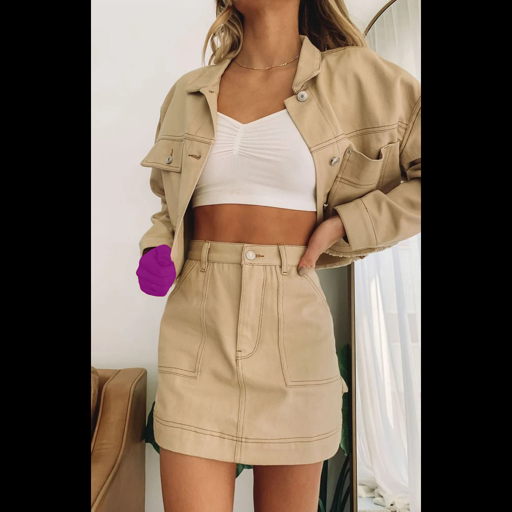

: 

In [34]:
def sanity_check(ds, row=102, mask_row=2,image_col="image", metadata_col='mask_metadata'):
    image = ds[row][image_col]
    image = resize_image_pil(image)

    polygons = ds[row][metadata_col][mask_row]['polygons']
    label = ds[row][metadata_col][mask_row]['label']
    score = ds[row][metadata_col][mask_row]['score']
    
    mask = convert_coco_polygons_to_mask(polygons, 1024, 1024)
    mask_image = Image.fromarray(mask)
    overlay = overlay_mask(image, mask_image, opacity=0.8)

    print(f"Label: {label}")
    print(f"Score: {score}")
    display(overlay.resize((512, 512)))

import random 
updated_ds = pd
metadata_col = 'metadata'
row = random.randint(0, len(updated_ds))

mask_row = random.randint(0, len(updated_ds[row][metadata_col]) - 1)
sanity_check(updated_ds, row, mask_row, metadata_col=metadata_col)